### Mapp coordinate to country and state


In [ ]:
!pip install geopy

import pandas as pd
import numpy as np

### Using geopy
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="geoapiExercises")

def city_state_country(row):
    coord = f"{row['latitude']}, {row['longitude']}"
    location = geolocator.reverse(coord, exactly_one=True, timeout = 200, language='en')

    if location == None:
      row['city'] = ''
      row['state'] = ''
      row['country'] = ''
    else:
      address = location.raw.get('address', {})
      city = address.get('city', '')
      state = address.get('state', '')
      country = address.get('country', '')
      row['city'] = city
      row['state'] = state
      row['country'] = country
    return row

Data catalog:
https://developers.google.com/earth-engine/datasets/

EE guides:
https://developers.google.com/earth-engine/guides

Forum for questions on Geographic Information Systems:
https://gis.stackexchange.com/

###Import Packages

In [14]:
# Install packages
# geemap for map visualization
# pygrib for reading grib file
!pip install pygrib
!pip install geemap

In [15]:
# Import Earth Engine library
# Create a project and use project-id from https://console.cloud.google.com/
import ee
ee.Authenticate()
ee.Initialize(project = 'storied-radius-415117')

In [16]:
### Import geemap and pygrib
import geemap
import pygrib

# Other python packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
# Connect to Google drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


### Collect pixel data from Earth engine

In [18]:
import json
import geopandas as gpd

In [21]:
#### Read shape file vietnam
shapefile_path = 'gadm41_VNM_2.shp'
gdf = gpd.read_file(shapefile_path)

js = json.loads(gdf.to_json())
vietnam = ee.Geometry(ee.FeatureCollection(js).geometry())

##### Import NO2 Data
no2_daily = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2")\
 .filter(ee.Filter.date('2019-06-01', '2019-06-06'))\
 .filterBounds(vietnam)

# Select the band
no2_density = no2_daily.select('NO2_column_number_density')
no2_density_tropospheric = no2_daily.select('tropospheric_NO2_column_number_density')




In [24]:
### Function to collect pixel data

# This function loop through each image in the image collection, get the dataframes of pixel data and concatenate them together
# I do this because we collect pixel data for the whole world, if the data is smaller, we could use getRegion function for the image Collection directly
def collect_pixel_data(image_collection, geometry, scale_pixel):

  size_image_collection = image_collection.size().getInfo()
  list_image_collection = image_collection.toList(image_collection.size())

  # Loop through image collection
  for i in range(size_image_collection):

    img = ee.Image(list_image_collection.get(i))
    img_get_region = ee.ImageCollection(img).getRegion(geometry, scale = scale_pixel).getInfo()
    img_get_region_df = pd.DataFrame(img_get_region[1:len(img_get_region)], columns = img_get_region[0]).drop('time', axis = 1)

    # Joining dataframe
    if i == 0:
      result_df = img_get_region_df
    else:
      result_df = pd.concat([result_df, img_get_region_df])

    print("i = ", i, " Length DF: ", len(result_df))

  return result_df

In [25]:
# Collect ERA5 pixel at scale = 10000

# Define geographic domain
# world_geometry = ee.Geometry.Polygon([
#         -180, 90,
#         0, 90,
#         180, 90,
#         180, -90,
#         0, -90,
#         -180, -90], None, False)

# Create geometry by connecting the points
#geometry1 = ee.Geometry.Polygon([
#       80, 80,
#        80, 90,
#        90, 90,
#        80, 80
#       ], None, False)

no2_density_vietnam = collect_pixel_data(no2_density, vietnam, scale_pixel = 10000)
print(no2_density_vietnam.describe())
print(no2_density_vietnam.info())
print(no2_density_vietnam.head())

no2_density_vietnam.to_csv("drive/MyDrive/capstone_mief/no2_density.csv")

EEException: Request payload size exceeds the limit: 10485760 bytes.

In [ ]:
# Easier way if the data is small
img_get_region = no2_daily.getRegion(geometry1, scale = 10000).getInfo()
img_get_region_df = pd.DataFrame(img_get_region[1:len(img_get_region)], columns = img_get_region[0]).drop('time', axis = 1)

print(img_get_region_df.head())

       id  longitude   latitude  total_precipitation
0  201401  80.084808  80.174639             0.013981
1  201402  80.084808  80.174639             0.017386
2  201403  80.084808  80.174639             0.031722
3  201404  80.084808  80.174639             0.011471
4  201405  80.084808  80.174639             0.037275


In [ ]:
### I have another function to collect data for land area only
# It will collect the landcover from MODIS and using updateMask to filter land area only

# Function to collect pixel data with land area
def collect_pixel_data_land(image_collection, geometry, scale_pixel):

  # Land
  modisLandcover = ee.Image('MODIS/006/MCD12Q1/2020_01_01').select('LW')

  size_image_collection = image_collection.size().getInfo()
  list_image_collection = image_collection.toList(image_collection.size())

  # Collect pixel data for each image in ImageCollection and concatenate the result
  for i in range(size_image_collection):

    img = ee.Image(list_image_collection.get(i))
    land_area_img = img.updateMask(modisLandcover.eq(2))

    img_get_region = ee.ImageCollection(land_area_img).getRegion(geometry, scale = scale_pixel).getInfo()
    img_get_region_df = pd.DataFrame(img_get_region[1:len(img_get_region)], columns = img_get_region[0]).drop('time', axis = 1)

    if i == 0:
      result_df = img_get_region_df
    else:
      result_df = pd.concat([result_df, img_get_region_df])

  return result_df

### How GEE handles scale: https://developers.google.com/earth-engine/guides/scale

### Filter with shapefile, aggregate to monthly averages

In [ ]:
### Filter with shapefile



shapefile_path = 'gadm41_VNM_2.shp'  # Replace with the actual file name
gdf = gpd.read_file(shapefile_path)

js = json.loads(gdf.to_json())
vietnam = ee.Geometry(ee.FeatureCollection(js).geometry())

no2_vietnam = ee.ImageCollection("COPERNICUS/S5P/NRTI/L3_NO2") \
  .filter(ee.Filter.date('2019-01-01', '2020-01-01'))\
  .filterBounds(vietnam)

# Select the band
no2_density_vietnam = no2_vietnam.select('NO2_column_number_density')

# Aggregate to monthly averages
no2_density_vn_monthly = no2_density_vietnam \
    .reduce(ee.Reducer.mean()) \
    .resample('yearly') \

# Visualize the monthly averages
#Map = geemap.Map()
# Map.centerObject(geometry, 2)
# Map.addLayer(no2_density_vn_monthly, {}, 'Monthly Averages')
# Map.addLayerControl()
# Map



Map=geemap.Map()
Map.addLayer(no2_density_vn_monthly)

Map


EEException: Request payload size exceeds the limit: 10485760 bytes.

###Visualize Shape file

In [22]:
import geopandas as gpd
import matplotlib.pyplot as plt

<Figure size 5000x5000 with 0 Axes>

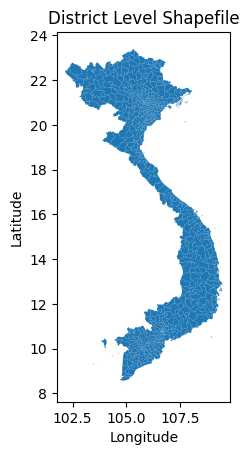

In [23]:
# Read the shapefile from session storage
gdf = gpd.read_file('gadm41_VNM_2.shp')
plt.figure(figsize=(50, 50))
# Visualize the shapefile
gdf.plot()
plt.title('District Level Shapefile')  # Add a title if desired
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')